**Scottie YANG Miaoyi**

Fall 2021

CS 251: Data Analysis and Visualization

Project 6: Supervised learning

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])
plt.rcParams.update({'font.size': 20})

np.set_printoptions(suppress=True, precision=5)

# Automatically reload external modules
%load_ext autoreload
%autoreload 2

## Task 3: Preprocess full spam email dataset 

Before you build a Naive Bayes spam email classifier, run the full spam email dataset through your preprocessing code.

Download and extract the full **Enron** emails (*zip file should be ~29MB large*). You should see a base `enron` folder, with `spam` and `ham` subfolders when you extract the zip file (these are the 2 classes).

Run the test code below to check everything over.

### 3a) Preprocess dataset

In [2]:
import email_preprocessor as epp

#### Test `count_words` and `find_top_words`

In [3]:
word_freq, num_emails = epp.count_words()

In [4]:
print(f'You found {num_emails} emails in the datset. You should have found 32625.')

You found 32625 emails in the datset. You should have found 32625.


In [5]:
top_words, top_counts = epp.find_top_words(word_freq)
print(f"Your top 5 words are\n{top_words[:5]}\nand they should be\n['the', 'to', 'and', 'of', 'a']")
print(f"The associated counts are\n{top_counts[:5]}\nand they should be\n[277459, 203659, 148873, 139578, 111796]")

Your top 5 words are
['the', 'to', 'and', 'of', 'a']
and they should be
['the', 'to', 'and', 'of', 'a']
The associated counts are
[277459, 203659, 148873, 139578, 111796]
and they should be
[277459, 203659, 148873, 139578, 111796]


### 3b) Make train and test splits of the dataset

Here we divide the email features into a 80/20 train/test split (80% of data used to train the supervised learning model, 20% we withhold and use for testing / prediction).

In [6]:
features, y = epp.make_feature_vectors(top_words, num_emails)

In [7]:
np.random.seed(0)
x_train, y_train, inds_train, x_test, y_test, inds_test = epp.make_train_test_sets(features, y)

In [8]:
print('Shapes for train/test splits:')
print(f'Train {x_train.shape}, classes {y_train.shape}')
print(f'Test {x_test.shape}, classes {y_test.shape}')
print('\nThey should be:\nTrain (26100, 200), classes (26100,)\nTest (6525, 200), classes (6525,)')

Shapes for train/test splits:
Train (26100, 200), classes (26100,)
Test (6525, 200), classes (6525,)

They should be:
Train (26100, 200), classes (26100,)
Test (6525, 200), classes (6525,)


### 3c) Save data in binary format

It adds a lot of overhead to have to run through your raw email -> train/test feature split every time you wanted to work on your project! In this step, you will export the data in memory to disk in a binary format. That way, you can quickly load all the data back into memory (directly in ndarray format) whenever you want to work with it again. No need to parse from text files!

- Use numpy's `save` function to make six files in `.npy` format (e.g. `email_train_x.npy`, `email_train_y.npy`, `email_train_inds.npy`, `email_test_x.npy`, `email_test_y.npy`, `email_test_inds.npy`).

In [9]:
np.save('data/email_train_x.npy', x_train)
np.save('data/email_train_y.npy', y_train)
np.save('data/email_train_inds.npy', inds_train)
np.save('data/email_test_x.npy', x_test)
np.save('data/email_test_y.npy', y_test)
np.save('data/email_test_inds.npy', inds_test)

## Task 4: Naive Bayes Classifier

After finishing your email preprocessing pipeline, implement the one other supervised learning algorithm we we will use to classify email, **Naive Bayes**.

### 4a) Implement Naive Bayes

In `naive_bayes_multinomial.py`, implement the following methods:
- Constructor
- `train(data, y)`: Train the Naive Bayes classifier so that it records the "statistics" of the training set: the log of the class priors (i.e. how likely an email is in the training set to be spam or ham?) and the log of the class likelihoods (the probability of a word appearing in each class — spam or ham).
- `predict(data)`: Combine the log class likelihoods and log priors to compute the log posterior distribution. The predicted class for a test sample is the class that yields the highest posterior probability.
- `accuracy(y, y_pred)`: The usual definition :)


#### Bayes rule ingredients: Priors and likelihood (`train`)

To compute class predictions (probability that a test example belong to either spam or ham classes), we need to evaluate **Bayes Rule**. This means computing the priors and likelihoods based on the training data. We store the log of the priors and the log of the likelihoods.

**Prior:** $$P_c = \frac{N_c}{N}$$ where $P_c$ is the prior for class $c$ (spam or ham), $N_c$ is the number of training samples that belong to class $c$ and $N$ is the total number of training samples.

**Likelihood:** $$L_{c,w} = \frac{N_{c,w} + 1}{N_{c} + M}$$ where
- $L_{c,w}$ is the likelihood that word $w$ belongs to class $c$ (*i.e. what we are solving for*)
- $N_{c,w}$ is the total count of **word $w$** in emails that are only in class $c$ (*either spam or ham*)
- $N_{c}$ is the total number of **all words** that appear in emails of the class $c$ (*total number of words in all spam emails or total number of words in all ham emails*)
- $M$ is the number of features (*number of top words*).

Store $Log(P_c)$ and $Log(L_{c,w})$ in the `log_class_priors` and `log_class_likelihoods` fields.

#### Bayes rule ingredients: Posterior (`predict`)

To make predictions, we now combine the prior and likelihood to get the posterior:

**Log Posterior:** $$Log(\text{Post}_{i, c}) = Log(P_c) + \sum_{j \in J_i}x_{i,j}Log(L_{c,j})$$

 where
- $\text{Post}_{i,c}$ is the posterior for class $c$ for test sample $i$(*i.e. evidence that email $i$ is spam or ham*). We solve for its logarithm.
- $Log(P_c)$ is the logarithm of the prior for class $c$.
- $x_{i,j}$ is the number of times the jth word appears in the ith email.
- $Log(L_{c,j})$: is the log-likelihood of the jth word in class $c$.

In [10]:
from naive_bayes_multinomial import NaiveBayes

#### Test `train`

In [11]:
num_test_classes = 4
np.random.seed(0)
data_test = np.random.random(size=(100, 6))
y_test = np.random.randint(low=0, high=num_test_classes, size=(100,))

nbc = NaiveBayes(num_classes=num_test_classes)
nbc.train(data_test, y_test)

print(f'Your log class priors are: {nbc.log_class_priors}\nand should be          [-1.42712 -1.34707 -1.38629 -1.38629].')
print(f'Your log class likelihoods shape is {nbc.log_class_likelihoods.shape} and should be (4, 6).')
print(f'Your log likelihoods are:\n{nbc.log_class_likelihoods}')


test_likelihoods = np.array(
[[-1.88939, -1.68757, -1.73893, -1.92213, -1.78302, -1.75022],
 [-1.79005, -1.7466,  -1.84883, -1.7786,  -1.85297, -1.73946],
 [-1.95787, -1.85664, -1.62705, -1.76927, -1.71753, -1.85681],
 [-1.67787, -1.70203, -1.83983, -2.09846, -1.78647, -1.70444]])
print(f'and should be\n{test_likelihoods}')

Your log class priors are: [-1.42712 -1.34707 -1.38629 -1.38629]
and should be          [-1.42712 -1.34707 -1.38629 -1.38629].
Your log class likelihoods shape is (4, 6) and should be (4, 6).
Your log likelihoods are:
[[-1.88939 -1.68757 -1.73893 -1.92213 -1.78302 -1.75022]
 [-1.79005 -1.7466  -1.84883 -1.7786  -1.85297 -1.73946]
 [-1.95787 -1.85664 -1.62705 -1.76927 -1.71753 -1.85681]
 [-1.67787 -1.70203 -1.83983 -2.09846 -1.78647 -1.70444]]
and should be
[[-1.88939 -1.68757 -1.73893 -1.92213 -1.78302 -1.75022]
 [-1.79005 -1.7466  -1.84883 -1.7786  -1.85297 -1.73946]
 [-1.95787 -1.85664 -1.62705 -1.76927 -1.71753 -1.85681]
 [-1.67787 -1.70203 -1.83983 -2.09846 -1.78647 -1.70444]]


#### Test `predict`

In [12]:
num_test_classes = 4
np.random.seed(0)
data_train = np.random.randint(low=0, high=num_test_classes, size=(100, 10))
data_test = np.random.randint(low=0, high=num_test_classes, size=(15, 10))
y_test = np.random.randint(low=0, high=num_test_classes, size=(100,))

nbc = NaiveBayes(num_classes=num_test_classes)
nbc.train(data_train, y_test)
test_y_pred = nbc.predict(data_test)

print(f'Your predicted classes are\n{test_y_pred}\nand should be\n[3 0 3 1 0 1 1 3 0 3 0 2 0 2 1]')

Your predicted classes are
[3 0 3 1 0 1 1 3 0 3 0 2 0 2 1]
and should be
[3 0 3 1 0 1 1 3 0 3 0 2 0 2 1]


### 4b) Spam filtering

Let's start classifying spam email using the Naive Bayes classifier.

- Use `np.load` to load in the train/test split that you created last week.
- Use your Naive Bayes classifier on the Enron email dataset!

**Question 7:** Print out the accuracy that you get on the test set with Naive Bayes. It should be roughly 89%.

In [13]:
import email_preprocessor as ep

In [14]:
x_train = np.load('data/email_train_x.npy')
y_train = np.load('data/email_train_y.npy')
inds_train = np.load('data/email_train_inds.npy')
x_test = np.load('data/email_test_x.npy')
y_test = np.load('data/email_test_y.npy')
inds_test = np.load('data/email_test_inds.npy')

In [15]:
# Write your Naive Bayes code here
# predict the classes of testing data
nbc_spam = NaiveBayes(num_classes=np.unique(y_train).shape[0])
nbc_spam.train(x_train, y_train)
spam_y_test_pred = nbc_spam.predict(x_test)

In [16]:
#print out accuracy
print(f'Accuracy: ' + "{:.2f}".format(nbc_spam.accuracy(y_test, spam_y_test_pred)*100) + "%.")

Accuracy: 89.24%.


### 4c) Confusion matrix

To get a better sense of the errors that the Naive Bayes classifer makes, you will create a confusion matrix. 

- Implement `confusion_matrix` in `naive_bayes.py`.
- Print out a confusion matrix of the spam classification results.

**Debugging guidelines**:
1. The sum of all numbers in your 2x2 confusion matrix should equal the number of test samples (6525).
2. The sum of your spam row should equal the number of spam samples in the test set (3193)
3. The sum of your ham row should equal the number of spam samples in the test set (3332)

In [17]:
cm = nbc_spam.confusion_matrix(y_test, spam_y_test_pred)
print('Confusion matrix: \n', cm)
print('\nSum of all numbers:', np.sum(cm))
print('\nSum of spam row and ham row:', np.sum(cm, axis = 1))

Confusion matrix: 
 [[3043  150]
 [ 552 2780]]

Sum of all numbers: 6525

Sum of spam row and ham row: [3193 3332]


**Question 8:** Interpret the confusion matrix, using the convention that positive detection means spam (*e.g. a false positive means classifying a ham email as spam*). What types of errors are made more frequently by the classifier? What does this mean (*i.e. X (spam/ham) is more likely to be classified than Y (spam/ham) than the other way around*)?

**Reminder:** Look back and make sure you are clear on which class indices correspond to spam/ham.

**Answer 8:**
Based on the confusion matrix:

True Positive: 3043

False Positive (Type I error): 150

False Negative (Type II error): 552

True Negative: 2780

True Positive Rate = TP/(TP+FN) = 3043/(3043+552) ≈ 84.64%

False Positive Rate = FP/(FP+TN) = 150/(150+2780) ≈ 5.12%

Therefore, Type II error is more frequent in this classifier.

It means that a ham email is more likely to be falsely predicted as spam (than a spam email being falsely predicted as a ham).

## Task 5: Comparison with KNN


- Run a similar analysis to what you did with Naive Bayes above. When computing accuracy on the test set, you may want to reduce the size of the test set (e.g. to the first 500 emails in the test set).
- Copy-paste your `confusion_matrix` method into `knn.py` so that you can run the same analysis on a KNN classifier.

In [18]:
from knn import KNN

In [19]:
KNNclassifier = KNN(num_classes=np.unique(y_train).shape[0])
KNNclassifier.train(x_train, y_train)

KNN_x_test = x_test[:500]
KNN_y_test = y_test[:500]

In [20]:
KNN_y_pred = KNNclassifier.predict(KNN_x_test, 3)

In [21]:
print(f'Accuracy: ' + "{:.2f}".format(KNNclassifier.accuracy(KNN_y_test, KNN_y_pred)*100) + "%.")

Accuracy: 92.80%.


In [22]:
cmKNN = KNNclassifier.confusion_matrix(KNN_y_test, KNN_y_pred)
print('Confusion matrix: \n', cmKNN)

Confusion matrix: 
 [[252  15]
 [ 21 212]]


**Question 9:** What accuracy did you get on the test set (potentially reduced in size)?

**Question 10:** How does the confusion matrix compare to that obtained by Naive Bayes (*If you reduced the test set size, keep that in mind*)?

**Question 11:** Briefly describe at least one pro/con of KNN compared to Naive Bayes on this dataset.

**Question 12:** When potentially reducing the size of the test set here, why is it important that we shuffled our train and test set?

**Answer 9:** About 92.80%.

**Answer 10:** It's more accurate (92.80% vs. 89.24%) but not by a lot. Considering we are using a reduced test size, the accuracy should be quite similar between two methods. Type II error of KNN is still more frequent than Type I.

**Answer 11:** Pro of KNN: Training takes much less time.
Con of KNN: 1) Takes more time in the testing process. 2) Hard to determine a good K value.

**Answer 12:** It's important because if we don't shuffle the training and testing class, when we reduce the test set size, we may not have enough information for each class and the result may be unbalanced.

## Extensions

### 0. Classify your own datasets

- Find datasets that you find interesting and run classification on them using your KNN algorithm (and if applicable, Naive Bayes). Analysis the performance of your classifer.

**For convinence, I selected the Iris dataset to run classification using KNN and Naive Bayes. I preprocessed the data to keep only "petalLength", "petalWidth" as x and y, and "species" as class.**

In [23]:
# 1. Load Iris Dataset
iris_dataset = np.loadtxt('data/iris.csv', skiprows=1, delimiter=',')
iris = iris_dataset[:, :2]
iris_class = iris_dataset[:, 2]

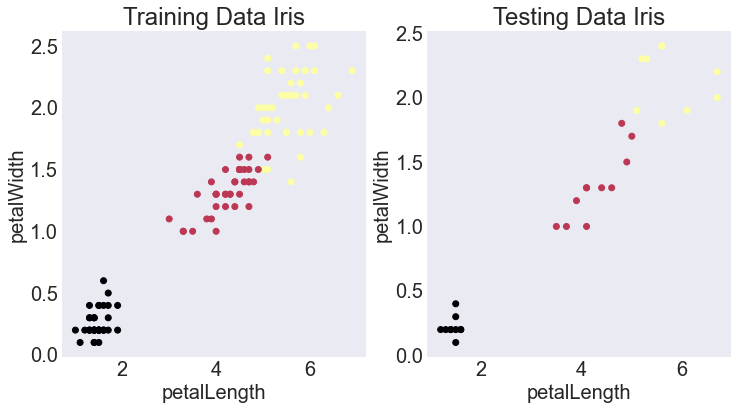

In [24]:
# 2. Makes training and testing dataset and visualize it
np.random.seed(0)
iris_train, iris_class_train, iris_inds_train, iris_test, iris_class_test, iris_inds_test = epp.make_train_test_sets(iris, iris_class)

fig, axs = plt.subplots(1, 2, figsize = (12, 6))
axs[0].scatter(iris_train[:, 0], iris_train[:, 1], c = iris_class_train, cmap = 'inferno')
axs[0].set_title('Training Data Iris')
axs[0].set_xlabel('petalLength')
axs[0].set_ylabel('petalWidth')
axs[0].grid(False)

axs[1].scatter(iris_test[:, 0], iris_test[:, 1], c = iris_class_test, cmap = 'inferno')
axs[1].set_title('Testing Data Iris')
axs[1].set_xlabel('petalLength')
axs[1].set_ylabel('petalWidth')
axs[1].grid(False)

plt.show()

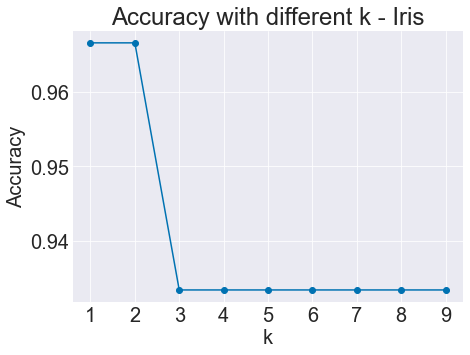

In [25]:
import time

# 3. Run classification using KNN
# 3.1 Train KNN (while recording the run time)
KNNiris = KNN(num_classes=np.unique(iris_class_train).shape[0])
start = time.time()
KNNiris.train(iris_train, iris_class_train)
KNN_train_time = time.time() - start

# 3.2 Find best K
ks = range(1, 10)
n_classes = np.unique(iris_class_train).shape[0]
accuracy = []

for k in ks:
    class_pred = KNNiris.predict(iris_test, k)
    acc = KNNiris.accuracy(y=iris_class_test, y_pred=class_pred)
    accuracy.append(acc)

plt.figure(figsize = (7, 5))
plt.plot(range(1, 10), accuracy, '-o')
plt.title('Accuracy with different k - Iris')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.xticks(range(1, 10))
plt.show()

**I observed that the accuracy drops when k is 3 or above, but the overall accuracy is still very high.**

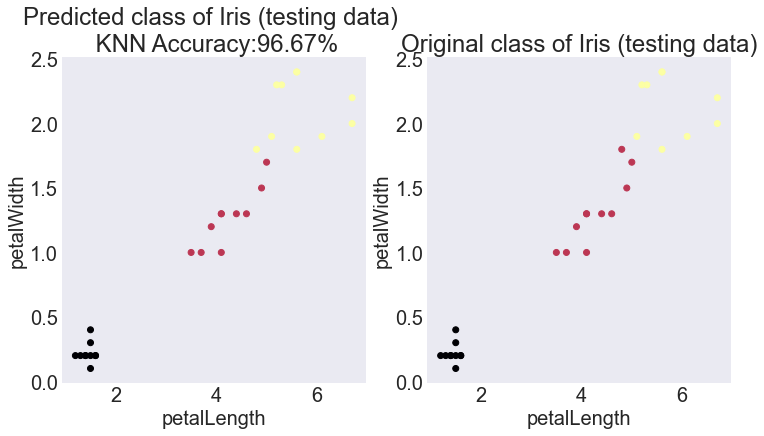

In [26]:
# We choose k=2
# 3.3 Predict the class (while recording the run time)
start = time.time()
KNNiris_pred = KNNiris.predict(iris_test, 2)
KNN_pred_time = time.time() - start

# 3.4 Calculate the accuracy, and plot both predict class of testing data and original class of testing data
KNNaccuracy = KNNiris.accuracy(y=iris_class_test, y_pred=KNNiris_pred)

fig, axs = plt.subplots(1, 2, figsize = (12, 6))
axs[0].scatter(iris_test[:, 0], iris_test[:, 1], c = KNNiris_pred, cmap = 'inferno')
axs[0].set_title('Predicted class of Iris (testing data) \n KNN Accuracy:' +  '{:.2f}'.format(KNNaccuracy*100) + '%')
axs[0].set_xlabel('petalLength')
axs[0].set_ylabel('petalWidth')
axs[0].grid(False)

axs[1].scatter(iris_test[:, 0], iris_test[:, 1], c = iris_class_test, cmap = 'inferno')
axs[1].set_title('Original class of Iris (testing data)')
axs[1].set_xlabel('petalLength')
axs[1].set_ylabel('petalWidth')
axs[1].grid(False)
plt.show()

In [27]:
KNN_run_time = KNN_train_time + KNN_pred_time

print('Accuracy of KNN: ' +  '{:.2f}'.format(KNNaccuracy*100) + '%')
print(f"Run time of KNN: {KNN_run_time}s.")

Accuracy of KNN: 96.67%
Run time of KNN: 0.0016210079193115234s.


**We could see although it doesn't get the class of all datapoints right, the accuracy of KNN is fairly high. Let's see how does it compare to the accuracy and run time of Naive Bayes.**

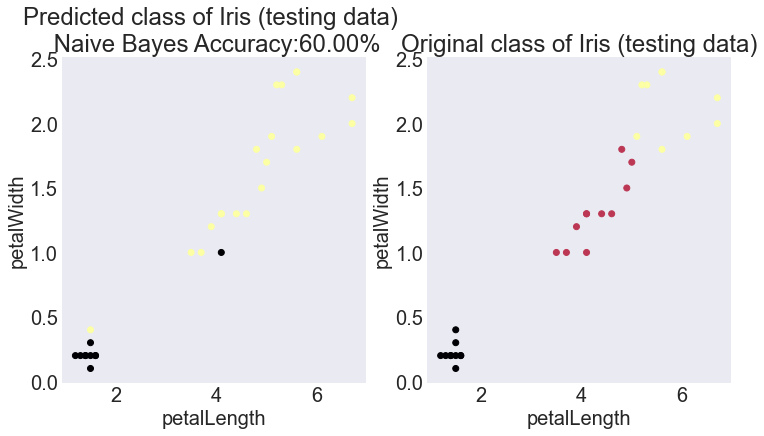

In [28]:
# 4. Run classification using Naive Bayes
# 4.1 Train Navie Bayes and predict the class (while recording the run time)
NBCiris = NaiveBayes(num_classes=np.unique(iris_class_train).shape[0])
start = time.time()
NBCiris.train(iris_train, iris_class_train)
NBCiris_pred = NBCiris.predict(iris_test)
NBC_run_time = time.time() - start

# 4.2 Calculate the accuracy, and plot both predict class of testing data and original class of testing data
NBCaccuracy = NBCiris.accuracy(y=iris_class_test, y_pred=NBCiris_pred)

fig, axs = plt.subplots(1, 2, figsize = (12, 6))
axs[0].scatter(iris_test[:, 0], iris_test[:, 1], c = NBCiris_pred, cmap = 'inferno')
axs[0].set_title('Predicted class of Iris (testing data) \n Naive Bayes Accuracy:' +  '{:.2f}'.format(NBCaccuracy*100) + '%')
axs[0].set_xlabel('petalLength')
axs[0].set_ylabel('petalWidth')
axs[0].grid(False)

axs[1].scatter(iris_test[:, 0], iris_test[:, 1], c = iris_class_test, cmap = 'inferno')
axs[1].set_title('Original class of Iris (testing data)')
axs[1].set_xlabel('petalLength')
axs[1].set_ylabel('petalWidth')
axs[1].grid(False)
plt.show()

In [29]:
print('Accuracy of Naive Bayes: ' +  '{:.2f}'.format(NBCaccuracy*100) + '%')
print(f"Run time of Naive Bayes: {NBC_run_time}s.")

Accuracy of Naive Bayes: 60.00%
Run time of Naive Bayes: 0.0024030208587646484s.


**Naive Bayes seems to have a lower accuracy (failure to distinguish a whole class) and a longer run time. I believe this dataset is suitable for Naive Bayes because even it works well with a smaller dataset, it sometimes has a low accuracy. We made a lot of effort, Naive Bayes just may not work well with such a simple dataset like this.**

### 1. Better text preprocessing

- If you look at the top words extracted from the email dataset, many of them are common "stop words" (e.g. a, the, to, etc.) that do not carry much meaning when it comes to differentiating between spam vs. non-spam email. Improve your preprocessing pipeline by building your top words without stop words. Analyze performance differences.

**I took a list of common stop words which are listed as:**

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]

**With those in mind, I implement a new function exclusive_words_count() in epp.py.**

In [30]:
# Running Naive Bayes again while excluding stop words
# 1. Using the new count_words_exclusive function, load and make new training and testing data
word_freq_ex, num_emails = epp.words_count_exclusive()
top_words_ex, top_counts_ex = epp.find_top_words(word_freq_ex)
features_ex, y_ex = epp.make_feature_vectors(top_words_ex, num_emails)

# 2. Running Naive Bayes with new data excluding stop words
np.random.seed(0)
x_train_ex, y_train_ex, inds_train_ex, x_test_ex, y_test_ex, inds_test_ex = epp.make_train_test_sets(features_ex, y_ex)

nbc_ex = NaiveBayes(num_classes=np.unique(y_train_ex).shape[0])
nbc_ex.train(x_train_ex, y_train_ex)
test_pred_ex = nbc_ex.predict(x_test_ex)

In [31]:
# 3. print out accuracy and compare to the Naive Bayes not excluding stop words
print(f'Accuracy (excluding stop words): ' + "{:.2f}".format(nbc_ex.accuracy(y_test_ex, test_pred_ex)*100) + "%.")
print('Accuracy (not excluding stop words): 89.24%')
# 4. print out confusion matrix and compare to the Naive Bayes not excluding stop words
cm_ex = nbc_ex.confusion_matrix(y_test_ex, test_pred_ex)
print('Confusion matrix (excluding stop words): \n', cm_ex)
print('Confusion matrix (not excluding stop words): \n', cm)

Accuracy (excluding stop words): 91.82%.
Accuracy (not excluding stop words): 89.24%
Confusion matrix (excluding stop words): 
 [[3070  123]
 [ 411 2921]]
Confusion matrix (not excluding stop words): 
 [[3043  150]
 [ 552 2780]]


**Since we excluded stop words, the accuracy is higher. Also we could see that although we are excluding stop words, there're still more Type II errors (False Negative) than Type I. However, the number of both Type I and Type II errors decreases when excluding stop words. It's functioning!**

### 2. Feature size

- Explore how the number of selected features for the email dataset influences accuracy and runtime performance.

### 3. Distance metrics
- Compare KNN performance with the $L^2$ and $L^1$ distance metrics

### 4. K-Fold Cross-Validation

- Research this technique and apply it to data and your KNN and/or Naive Bayes classifiers.

**KFold divides all the samples in k groups of samples (called folds). The prediction function is learned using k−1  folds, and the fold left out is used for test.
In this case, we try out Naive Bayes within each Fold by using sklearn module.**

In [32]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=4)
kf.get_n_splits(features)

num = 1
for train_index, test_index in kf.split(features):
    X_train, X_test = features[train_index], features[test_index[:-1]]
    y_train, y_test = y[train_index], y[test_index[:-1]]

    nbc_kfold = NaiveBayes(num_classes=np.unique(y_train).shape[0]) # Naive Bayes
    nbc_kfold.train(X_train, y_train)
    nbc_pred_kfold = nbc_kfold.predict(X_test)
    
    print(f'Accuracy of Naive Bayes for Fold No.{num} : ' + "{:.2f}".format(nbc_kfold.accuracy(y_test, nbc_pred_kfold)*100) + "%.\n")
    num += 1

Accuracy of Naive Bayes for Fold No.1 : 90.84%.

Accuracy of Naive Bayes for Fold No.2 : 92.35%.

Accuracy of Naive Bayes for Fold No.3 : 82.92%.

Accuracy of Naive Bayes for Fold No.4 : 80.09%.



**In this case, the accuracy of each fold is not the same. Using KFold can split data into training and test sets and help avoid model overfitting, and standardize the number of groups in test sets, etc.**

**In this case, to get a reliable accuracy of Naive Bayes model, we should consider different fold groups comprehensively.**

### 5. Email error analysis

- Dive deeper into the properties of the emails that were misclassified (FP and/or FN) by Naive Bayes or KNN. What is their word composition? How many words were skipped because they were not in the training set? What could plausibly account for the misclassifications?